# Physics 260 Final Project:
## Modeling the transmission of action potentials with the Hodgkin-Huxley model
### Louis Gouirand - December 11, 2018

## Abstract
The Hodgkin-Huxley model provides a mathematical representation of how action potentials (which enable neuronal messages to travel through the nerves) are initiated and then propagated. This model, created in 1952, was revolutionary and received the Nobel Prize for Physiology or Medicine in 1963 [1]. The goal of this project was to implement this model through Python code to then derive an estimation of the speed of action potentials. We will see how the model did enable us to obtain such estimation, as well as confirm the relationship between the diameter of a neuron fiber and the speed of action potentials.<br>
The speed was obtained by modeling a neuron fiber of fixed length and dividing its membrane into several electrical circuits. By producing a short current spike through the fiber (which is how the action potential is produced physiologically), and recording how long it took to travel the fiber of known length, the speed was obtained using the simple relation $$ velocity = \frac{length}{time} $$ <br>
Considering the wide range of values that the speed of action potentials take [2], it will be shown the model produced satisfying results. 

## Introduction and Motivation
One of the main reasons I was appealed towards this topic was its multidisciplinary aspect. The Hodgkin-Huxley model is fascinating in the fact that it combines physics and mathematics to explain a physiological phenomenon that is unknown to most of us. 
Furthermore, the process of transmitting action potentials through nerves to our brain is literally at the center of every action we take. I believe anyone would thus be interested in learning more about such process since it is so fundamental to our inner-workings.

## Background
We will present here the basics of action potential transmission here, first from a biological point of view, and then through the Hodgkin-Huxely model. 
#### Biological description
One can think of a neuron fiber as a cylinder. The action potential is transmitted by changing the polarity of the membrane. Ions flow in and out of the membrane as the action potential travel through to change the polarity [2]. Here is a visual representation of the process: 

In [1]:
# necessary because the image is originally very big
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://img.tfd.com/hc/bio/fig153.jpg", width=400, height=100) # [3]

One thing to say however is that, although the above illustration shows the potential of a membrane "at rest" is negative, we will assume it to be 0mV to simplify our calculations. It should be understood this will not impact our conclusions since we are only concerned about the transmission of the signal rather than the signal itself. Moreover, at the time Hodgkin and Huxely developed their model, it was still thought the resting potential of the membrane was 0. [1]

#### The Hodgkin-Huxley model
The model represents the neuron fiber by the following eletrical circuit [4]:
![Hodgkin-Huxley representation of the neuron fiber membrane](http://icwww.epfl.ch/~gerstner/SPNM/img92.gif)
<br>Here the capacitor represents the membrane, the components "K" and "Na" represents the channels through which ions can flow in and out of the fiber. Finally the constant resistance represents a third kind of ion leakage channel. The inflowing current represents the current coming into the fiber when an action potential has been initiated. 
The model provides equations to obtain the current through the "K", "Na" and constant resistance channels. Using the current rule, we can obtain the current through the capacitor as such: 
$$ I_C = I - (I_N + I_K + I_R)$$
Then, we can obtain the change in the membrane's potential by deriving the following differential equation: 
$$ C = \frac{Q}{u} $$ (u is the membrane's potential / capacitor voltage). Then the previous equation becomes
$$ C \frac{du}{dt} = I - (I_N + I_K + I_R) $$ and we assumed previously that $$ u(t_0) = 0 mV $$

The model provides equations on how to compute the necessary currents. Note that the m, n and h coefficients obey other equations given by the model, but for simplicity those will only be included in the code portion. 
$$ I_N = g_N m^3 h (u - E_N)$$
$$ I_K = g_K n^4 (u - E_K)$$
$$ I_R = g_L (u - E_L)$$
Since the membrane voltage u and the current in are times dependent, we get the following equation
$$ \frac{du}{dt} = C [I - g_N m^3 h (u - E_N) - g_K n^4 (u - E_K) - g_L (u - E_L)] $$
<br>Where the values of the above constants are as such: ![Constants of the HH model](http://icwww.epfl.ch/~gerstner/SPNM/img97.gif)

(alpha and beta values will come in useful for the equations of the m, n and h coefficients mentioned previously.)<br>
Sources: [4]

#### Cable theory equation
Finally, to implement our final model, we will need a way of finding the current going into the different "sub-circuits" of the membrane to use the Hodgkin-Huxley equations. To help visualize what the final model will look like here is a diagram [5]. The cylinder represents the neuron fiber. Each circuit will be slightly different (to respect the HH model) but the diagram represents the general outline. 
![cable theory image](https://ars.els-cdn.com/content/image/1-s2.0-S1878778915000320-gr3.jpg)
<br>Using the above diagram, let <i>dx</i> be the horizontal length of each subsection of the membrane (or "cable" here). Let <i>deltaR</i> be the resistance of the section of the central "wire" separating two adjacent circuits. Finally, let <i>V_M(x, t)</i> be the potential of each circuits at distance <i>x</i> at time <i>t</i>. We get the following equation: 
$$ V_M(x+dx, t) - V_M(x, t) = -I_c(x, t) \Delta R $$
$$ I_c(x, t) = - \Delta R \frac {dV_M(x, t)}{d x}(x, t) $$

(using the limit)

Sources: [5]

## Setup
#### General outline
As said above, we will be representing a neuron as a succession of circuits to represent different pieces of the membrane. Each of the circuits will follow the representation given by the Hodgkin-Huxley model. To trigger the action potential we will simulate a very short current spike, which will go through the first circuit of the membrane.

#### Starting with the code
To accomplish this, we define a class representing a ciruit of the Hodkin-Huxley model. The class will keep track of different value properties as well as contain methods to implement the equations for the <i>m</i>, <i>n</i> and <i>h</i> coefficients as well as the currents through the different segments of the circuit.

In [2]:
# Necessary libraries for the programming portion
import numpy as np              ## for numerical functions
import matplotlib.pyplot as plt ## for plots
from math import exp            ## necessary for calculations of m, n and h

In [3]:
class HHcircuit: # Representation of the circuit of the HH model, physically represents 
                 # membrane and ion channels of a neuron fiber
        
    def __init__(self, gNa, gK, gL, C, mu, E_Na, E_K, E_L): # constructor
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.m = 0.0
        self.n = 0.0
        self.h = 0.0
        self.C = C
        self.mu = mu
        
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        
        self.recorded_mu = []
        
    def update_m(self, dt): # updates m using diff eqs of HH model
        alpha_m = (2.5-0.1*self.mu)/(exp(2.5-0.1*self.mu) - 1)
        beta_m = 4*exp(-self.mu / 18)
        dm = dt * (alpha_m*(1-self.m) - beta_m*self.m)
        self.m += dm
        return self.m
    
    def update_n(self, dt): # updates n using diff eqs of HH model
        alpha_n = (0.1-0.01*self.mu)/(exp(1-0.1*self.mu) - 1)
        beta_n = 0.125*exp(-self.mu / 80)
        dn = dt * (alpha_n*(1-self.n) - beta_n*self.n)
        self.n += dn
        return self.n
    
    def update_h(self, dt): # updates h using diff eqs of HH model
        alpha_h = 0.07*exp(-self.mu / 20)
        beta_h = 1 / (exp(3-0.1*self.mu)+1)
        dh = dt * (alpha_h*(1-self.h) - beta_h*self.h)
        self.h += dh
        return self.h
    
    def sum_I_channels(self): # returns current through capacitor 
        s = 0
        s += self.gNa* (self.m)**3 *self.h*(self.mu-self.E_Na)
        s += self.gK* (self.n)**4 *(self.mu-self.E_K)
        s += self.gL*(self.mu - self.E_L)
        return s

We also store some physiological constants we will need [4]:

In [4]:
# assuming rest membrane potential of 0 mV
E_Na = 115.0 # mV
E_K = -12.0
E_L = 10.6
gNa = 120.0 # mS/cm^2
gK = 36.0
gL = 0.3
mu0 = 0.0 # assumes rest potential of membrane is 0mV

#### Preliminary check
We can check the current simplified model we have makes sense by only using one capacitor and running a current pulse through it. It should represent what happens at a lower scale of what we will do later. Moreover, the code will serve as a shell for our further developments. 
We will verify the model makes sense by obtaining and plotting the membrane potential at different times and see if it matches known scientifical results. 
<br>For this we first define a short function that returns an array of the membrane's voltage and an array of the different corresponding times. We will then plot the results

In [5]:
def run_experiment(T, I_peak, C): 
    neuron = HHcircuit(gNa, gK, gL, C, mu0, E_Na, E_K, E_L)
    recorded_mu = []
    times = []

    t_steps = 10000
    dt = T / t_steps
    t = 0.0 # ms

    first_pass = False # enables to have a current peak of duration dt only

    for i in range(t_steps):
        # update HH model coefficients
        neuron.update_n(dt)
        neuron.update_m(dt)
        neuron.update_h(dt)

        # Update voltage through Capacitor (membrane)
        sum_currents = I_peak - neuron.sum_I_channels()

        d_mu = sum_currents / neuron.C * dt
        neuron.mu += d_mu

        # save and update data
        recorded_mu.append(neuron.mu)
        times.append(t)
        t += dt
        
        # makes sure the current peak is just a pulse of duration dt
        if not first_pass: 
            I_peak = 0.0
            first_pass == True
    
    return recorded_mu, times

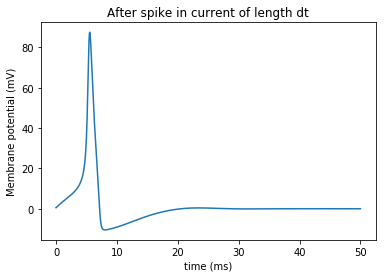

In [6]:
# Plotting the results
recorded_mu, times = run_experiment(50.0, 100.0, 1.0)

plt.plot(times, recorded_mu)
plt.xlabel("time (ms)")
plt.ylabel("Membrane potential (mV)")
plt.title("After spike in current of length dt")
plt.show()


The graph is corresponding to what experiments have shown the evolution of the membrane potential to be when exposed to an action potential. [2]
#### Finding the duration of the transmission
Our next steps towards our final model is to define a function to measure how long the signal (action potential) took to travel through the circuit. This was a bit challenging as it required some calibration but we will use the following method. 

We will first detect the point at which the membrane potential crosses the mu = 0 axis. After that point, we will consider the signal as fully transmitted as soon as the membrane potential is stable. We will find that point by seeing when two succesive recordings of the membrane potential are at very small values. The following functions handles this. 

In [7]:
def find_period(recorded_mu, times):
    max_val = max(recorded_mu)
    axis_cross = False
    
    for i in range(1, len(recorded_mu)):
        # checks if 2 values in a row are of different sign (indicates x-axis cross)
        if recorded_mu[i]/recorded_mu[i-1] < 0: 
            axis_cross = True
        if axis_cross:
            if abs(recorded_mu[i]) < 1.0e-3 and abs(recorded_mu[i-1]) < 1.0e-3:
                return times[i]
    return 2*times[-1]  # indicates the period for the experiment chosen was too small as the potential
                        # oscillation is not complete

#### Putting it all together
Finally, using our previous work we construct a coded representation of the layout presented at the beginning of our "Setup" section. This will be done through the implementation of a new function. Which takes the diameter and length of the neuron fiber wanted, as well as the amplitude of the current spike to create the action potential. The function will return an array with the membrane potential of each subcircuits at each time t, along with an array of the different times at which updates are made. Finally we will need the length of each subsections of the fiber to calculate the speed.

To obtain the speed we will first find the time at which the signal has been fully transmitted by the last subcircuit. Since the signal enters the first subcircuit at time t = 0, the previously mentioned time will give us the time in which the signal travelled the distance separating the end of the first and last subcircuits. 

That is all we need as we will use known physiological constants for the rest of the numerical values needed (including some new ones, [6], [7]).

In [8]:
# Additional physiological constants
C_per_area = 1.0 # microF/cm^2,
R_cyto_per_L = 70.0 # ohms/cm

In [9]:
def run_experiment2(diam_fiber, neuron_length, I_peak): # in cm and mA
    area = np.pi * diam_fiber * neuron_length # cm^2
    C = area * C_per_area # microF/cm^2, capacitance of the entire fiber
    
    L_steps = 100
    dL = neuron_length / L_steps # length of one subsections
    dC = np.pi * diam_fiber * dL * C_per_area # capacitance of one "subcircuit"

    dR = dL * R_cyto_per_L # resistance of one "subsegment" of the central membrane axis
    
    I_central = [] # contains currents going into each subcircuits at current time
    mus_array = [] # array of arrays of membrane potential at different time for each "subsection"
    neurons_array = [] # array containing class instances of each "subcircuit"

    # initializing the 3 arrays declared above
    n = HHcircuit(gNa, gK, gL, dC, mu0, E_Na, E_K, E_L) 
    for i in range(L_steps): 
        neurons_array.append(n)
        mus_array.append([])
        I_central.append(0)

    I_central[0] = I_peak # instantiates current spike going into first subcircuit
    times = [] # array of different times where updates are done
    T = 1.5 # ms, total runtime of the experiment
    t_steps = 10000
    dt = T / t_steps
    t = 0.0 # ms

    for t_i in range(t_steps): 
        
        for x in range(L_steps):
            neuron = neurons_array[x]
            # update HH model coefficients
            neuron.update_n(dt)
            neuron.update_m(dt)
            neuron.update_h(dt)
            
            # Update voltage through Capacitor (membrane)
            sum_currents = I_central[x] - neuron.sum_I_channels()
            d_mu = sum_currents / neuron.C * dt
            neuron.mu += d_mu

            # save and update data
            neurons_array[x] = neuron
            mus_array[x].append(neuron.mu)

            if x==0: # handling edge case (literally) for cable equation
                dV_dx = 0.0
            else:
                dV_dx = (mus_array[x][-1] - mus_array[x-1][-1]) / dL
            I_central[x] = - dR * dV_dx # cable equation

        times.append(t)
        t += dt
        
    return times, mus_array, dL

In [10]:
def speed(mus_array, times, neuron_length, dL):
    T_last = find_period(mus_array[-1], times)
    speed_units = (neuron_length - dL) / T_last # cm/ms
    return speed_units * 10**1 # m/s

## Results and Conclusions
#### Results
Now that we have our complete model, we will put it to use to derive the speed of action potentials travelling our bodies. We will use a neuron of length 1 cm and diameter 1 cm as that is a rather typical value [8]. 

Note that the value of the voltage does not really matter. As long as it is above a certain threshold, the induced peak in potential will be the same [2].

In [11]:
neuron_length = 1.0 # cm
I_peak = 10.0 # mA
times, mus_array, dL = run_experiment2(1.0, neuron_length, 10.0)

In [12]:
s = speed(mus_array, times, neuron_length, dL)
print("Speed of action potential: " + str(s) + " meters per second")

Speed of action potential: 21.51940006521102 meters per second


Previous experimental reuslts [9] indicate we should expect a speed between 35 and 75 meters per second. While our predication falls a bit short, we still are in the right order of magnitude. One thing to notice too is that our previous source indicates speed should scale with the diameter of the fiber our model reflects that. One way of showing that is to obtain the speed predicted by the model for a bigger diameter (we would expect the speed to be bigger than 21.5 m/s then). (Because the runtime is so long every time we call run_experiment2(), we will just try one additional value). 

In [13]:
times, mus_array, dL = run_experiment2(10.0, neuron_length, 10.0)
s = speed(mus_array, times, neuron_length, dL)
print("Speed of action potential: " + str(s) + " meters per second")

Speed of action potential: 55.3227158424133 meters per second


#### Conclusions
We saw our model does fall slighly short concerning the exact value of the speed of action potentials. This margin of error could potentially be attributed to our find_period() function. Indeed, additional calibration to find the end of the transmission signal may be necessary to obtain a value closer to what has been physically recorded. 

However, the model does show very well the evolution of the membrane potential when exposed to an action potential.
Futhermore, we were able to observe that, as predicted by actual expirements, the speed of action potential scales with the diameter of neuron fibers. It will be interesting to note that the first approach to the project that was taken was to represent the whole neuron fiber by only one Hodgkin-Huxley circuit. However that approach was unsuccesful as it was not showing that relationship between diameter of fiber and speed of action potential. 

Another interesting element to think about is that, this relationship between neuron fiber diameter and speed of action potential actually helps explain part of the structure of our nervous system. Indeed, it is because the neuron fibers of the peripheral nervous system (which contains the spinal cord [10]) of the spinal cord are much thicker than those of other parts of our body [11] that the spinal cord serves as the main path for neuronal messages as it provides higher transmission speeds.

Overall, the Hodgkin-Huxley model provides a very good representation of our action potential transmission system. Although we now possess powerful measurement abilities, the model is still of great interest as it unifies biological phenomenons and physical phenomenons. It provides an additional step towards a Grand Unified Theory of our universe's phenomenons!

### Sources
[1] Wikipedia, Article on the Hodgkin-Huxley model. URL: https://en.wikipedia.org/wiki/Hodgkin–Huxley_model

[2] Wikipedia, Article "Action Potential". URL: https://en.wikipedia.org/wiki/Action_potential

[3] Medical Dictionnary, "Depolarization". URL: https://medical-dictionary.thefreedictionary.com/phase+4+depolarization

[4] EPFL, Lausanne Switzerland, Prof. Gerstner's website. URL: http://icwww.epfl.ch/~gerstner/SPNM/node14.html

[5] University of Pittsburgh, Dept of Mathematics Website. URL: http://www.math.pitt.edu/~bdoiron/assets/ermentrout-and-terman-ch-1.pdf (Section 1.6)

[6] UPenn, Neurology lab manual. URL: https://www.sas.upenn.edu/LabManuals/BBB251/NIA/NEUROLAB/MEMB/lipidbil.htm

[7] core.ac.uk, Paper on "The electrical resistivity of the cytoplasm". URL: https://core.ac.uk/download/pdf/82549334.pdf

[8] Wikipedia, Article "Axon". URL: https://en.wikipedia.org/wiki/Axon 

[9] Electromyography and Neuromuscular Disorders: Clinical-Electrophysiologic Correlations, David C. Preston M.D. URL for table used: https://qph.fs.quoracdn.net/main-qimg-1633157491567f70891e2dcd8fc3c094

[10] Wikipedia, Article on the peripheral nervous system. URL: https://en.wikipedia.org/wiki/Peripheral_nervous_system

[11] Wikipedia, Article "Neuron". URL: https://en.wikipedia.org/wiki/Neuron

Thanks for reading through!